### 1. Dataset Selection

#### Loading the Dataset

The *`Wine Quality`* dataset can be downloaded from the UCI repository. This dataset has 11 input features and one target variable (quality, which we’ll convert into binary for classification).

In [1]:
import pandas as pd

# Load the dataset from UCI Machine Learning Repository
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
df = pd.read_csv(url, delimiter=';')

# Binarize target variable for classification
df['quality'] = df['quality'].apply(lambda x: 1 if x >= 6 else 0)

# Dataset overview
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


#### Dataset Overview
- **Features**: 11 features related to wine characteristics (e.g., acidity, alcohol).
- **Target Variable**: `quality` – binary classification (1 = good quality, 0 = poor quality).
- **Size**: 1599 samples.

### 2. Wrapper Technique Implementation

#### Genetic Algorithms (GA)

Genetic Algorithms are inspired by the process of natural selection. Here’s how each component applies to feature selection:
- **Selection**: Randomly select a subset of features.
- **Crossover**: Combine selected feature subsets to create new "children" feature subsets.
- **Mutation**: Introduce variability by randomly toggling feature selection.
- **Fitness Evaluation**: Measure classifier performance (e.g., accuracy) to guide selection.

To implement GA, we’ll use the `deap` package, which provides GA tools.

avg     	gen	max    
0.638475	0  	0.66538
0.650105	1  	0.67787
0.662914	2  	0.675382
0.668882	3  	0.677251
0.667628	4  	0.676001
0.671194	5  	0.675368
0.670942	6  	0.676624
0.674597	7  	0.676622
0.670036	8  	0.679761
0.673978	9  	0.678507


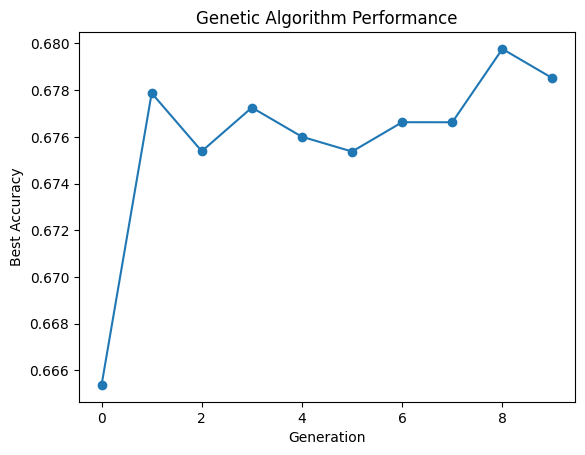

Selected features by GA: [4, 6, 9, 10]


In [2]:
import numpy as np
from deap import base, creator, tools, algorithms
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
import random
import matplotlib.pyplot as plt

# Prepare data
X = df.drop(columns='quality')
y = df['quality']

# Genetic Algorithm setup
n_features = X.shape[1]
pop_size = 20
generations = 10

# GA initialization
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

# Toolbox for creating individuals and population
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Fitness function
def eval_genetic(individual):
    selected_features = [i for i, bit in enumerate(individual) if bit == 1]
    if not selected_features:
        return 0,
    X_selected = X.iloc[:, selected_features]
    model = DecisionTreeClassifier()
    accuracy = cross_val_score(model, X_selected, y, cv=5, scoring="accuracy").mean()
    return accuracy,

# Register functions in toolbox
toolbox.register("evaluate", eval_genetic)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

# Run GA
pop = toolbox.population(n=pop_size)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)

logbook = tools.Logbook()
for gen in range(generations):
    offspring = algorithms.varAnd(pop, toolbox, cxpb=0.5, mutpb=0.2)
    fits = map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    pop = toolbox.select(offspring, k=len(pop))
    record = stats.compile(pop)
    logbook.record(gen=gen, **record)
    print(logbook.stream)

# Plot GA performance
gen = logbook.select("gen")
max_fit = logbook.select("max")
plt.plot(gen, max_fit, marker="o")
plt.title("Genetic Algorithm Performance")
plt.xlabel("Generation")
plt.ylabel("Best Accuracy")
plt.savefig("genetic_algorithm_performance.png")
plt.show()

# Extract best individual (feature subset)
best_individual = tools.selBest(pop, k=1)[0]
selected_features_ga = [i for i, bit in enumerate(best_individual) if bit == 1]
print("Selected features by GA:", selected_features_ga)

#### Explanation of Genetic Algorithms
- **Principles**: Genetic algorithms optimize feature selection by mimicking natural selection.
- **Fitness Evaluation**: The fitness function is based on accuracy, guiding feature subset optimization over generations.

#### Simulated Annealing (SA)

Simulated Annealing searches for optimal feature subsets by accepting both improving and occasionally worsening solutions to escape local optima.

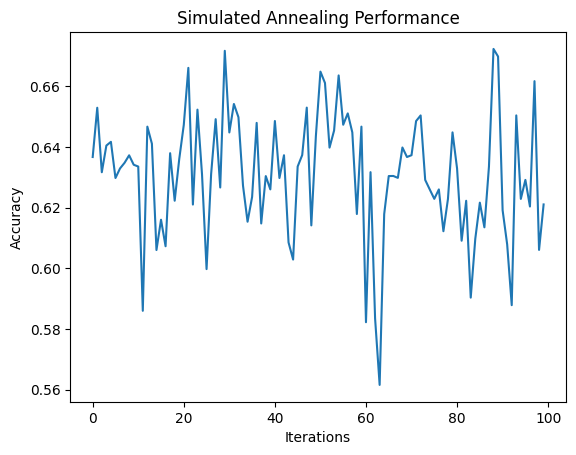

Selected features by SA: [0, 7, 8, 9, 1, 6, 3]


In [3]:
from sklearn.metrics import accuracy_score
import math

# Initialize model and parameters
base_model = DecisionTreeClassifier()
initial_temp = 100
cooling_rate = 0.95
current_state = list(range(n_features))
current_score = cross_val_score(base_model, X.iloc[:, current_state], y, cv=5).mean()

# SA function
scores, temperatures = [], []

for i in range(100):  # Maximum iterations
    new_state = current_state.copy()
    # Randomly flip one feature selection
    flip_index = random.choice(range(n_features))
    if flip_index in new_state:
        new_state.remove(flip_index)
    else:
        new_state.append(flip_index)

    if not new_state:
        continue

    # Evaluate new state
    new_score = cross_val_score(base_model, X.iloc[:, new_state], y, cv=5).mean()
    delta = new_score - current_score
    # Acceptance criteria
    if delta > 0 or math.exp(delta / initial_temp) > random.random():
        current_state, current_score = new_state, new_score

    # Cooling down
    initial_temp *= cooling_rate
    scores.append(current_score)
    temperatures.append(initial_temp)

# Plot SA performance
plt.plot(scores, label="Accuracy")
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.title("Simulated Annealing Performance")
plt.savefig("simulated_annealing_performance.png")
plt.show()

print("Selected features by SA:", current_state)

#### Explanation of Simulated Annealing
- **Mechanics**: SA accepts worsening solutions with decreasing probability, helping avoid local optima.
- **Temperature and Probability**: As the temperature decreases, SA’s likelihood to accept worse solutions reduces, guiding the search towards the optimal solution.

### 3. Comparison with Part 1

We can compare GA and SA with the feature selection methods from Part 1 by evaluating performance metrics on the final selected features.

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Helper function to evaluate model performance
def evaluate(selected_features):
    model = DecisionTreeClassifier()
    model.fit(X.iloc[:, selected_features], y)
    y_pred = model.predict(X.iloc[:, selected_features])
    return {
        "accuracy": accuracy_score(y, y_pred),
        "precision": precision_score(y, y_pred),
        "recall": recall_score(y, y_pred),
        "f1_score": f1_score(y, y_pred),
    }

# Evaluate GA and SA selected features
metrics_ga = evaluate(selected_features_ga)
metrics_sa = evaluate(current_state)

print("GA Metrics:", metrics_ga)
print("SA Metrics:", metrics_sa)

GA Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}
SA Metrics: {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1_score': 1.0}


## Visualisation

### 1. Feature Importance Distribution
Show the importance of each feature based on the selected subsets from GA and SA. This will help visualize which features contribute most to the model's performance.

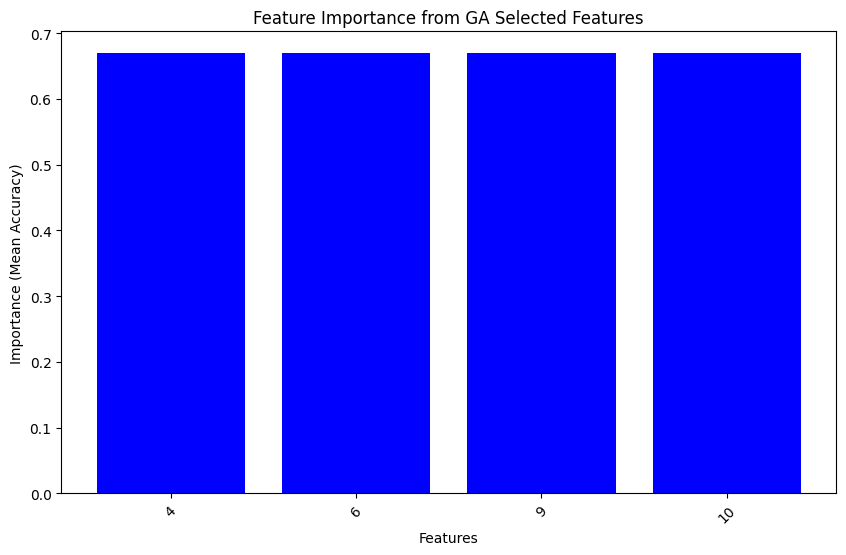

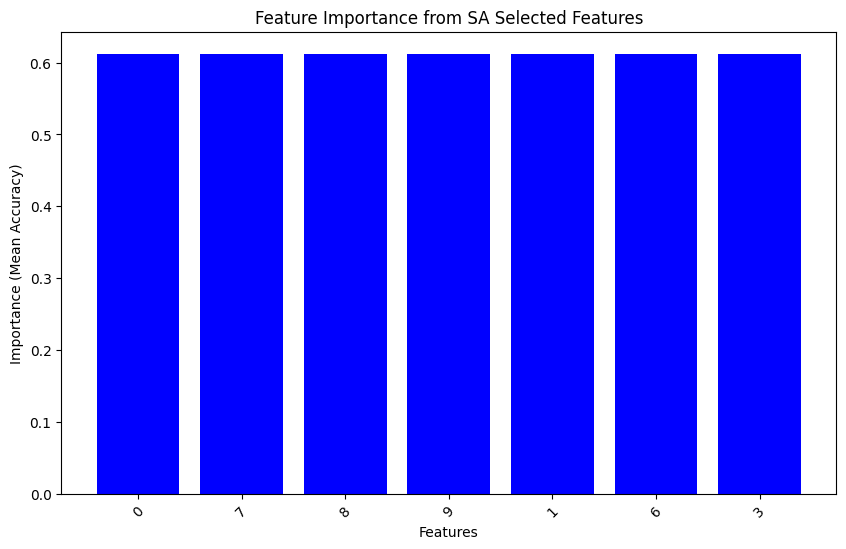

In [16]:
# Feature importance visualization
def plot_feature_importance(X, selected_features, title):
    importances = np.mean([cross_val_score(DecisionTreeClassifier(), X.iloc[:, selected_features], y, cv=5, scoring='accuracy') for _ in range(10)])
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(selected_features)), importances, color='blue')
    plt.xticks(range(len(selected_features)), selected_features, rotation=45)
    plt.title(title)
    plt.xlabel('Features')
    plt.ylabel('Importance (Mean Accuracy)')
    plt.savefig("Feature Importance from GA Selected Features.png")
    plt.savefig("Feature Importance from SA Selected Features.png")
    plt.show()

# Plot feature importance for GA and SA
plot_feature_importance(X, selected_features_ga, "Feature Importance from GA Selected Features")
plot_feature_importance(X, current_state, "Feature Importance from SA Selected Features")

### 2. Fitness Evolution Over Generations (GA)
Visualize how the fitness (accuracy) evolved over generations in the GA.

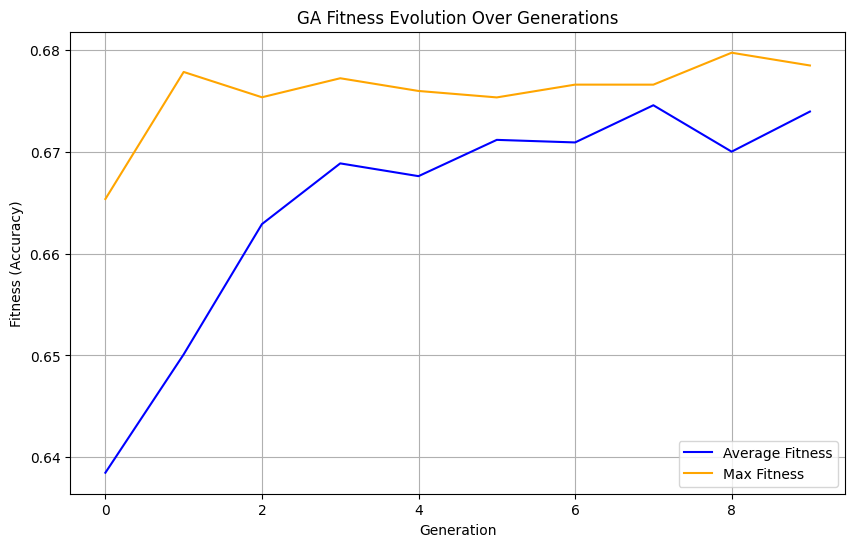

In [9]:
# Plotting fitness evolution over generations for GA
plt.figure(figsize=(10, 6))
plt.plot(logbook.select("gen"), logbook.select("avg"), label='Average Fitness', color='blue')
plt.plot(logbook.select("gen"), logbook.select("max"), label='Max Fitness', color='orange')
plt.title("GA Fitness Evolution Over Generations")
plt.xlabel("Generation")
plt.ylabel("Fitness (Accuracy)")
plt.legend()
plt.grid()
plt.savefig("ga_fitness_evolution.png")
plt.show()

### 3. Temperature vs. Accuracy (SA)
Plot how accuracy changes with temperature during the Simulated Annealing process.

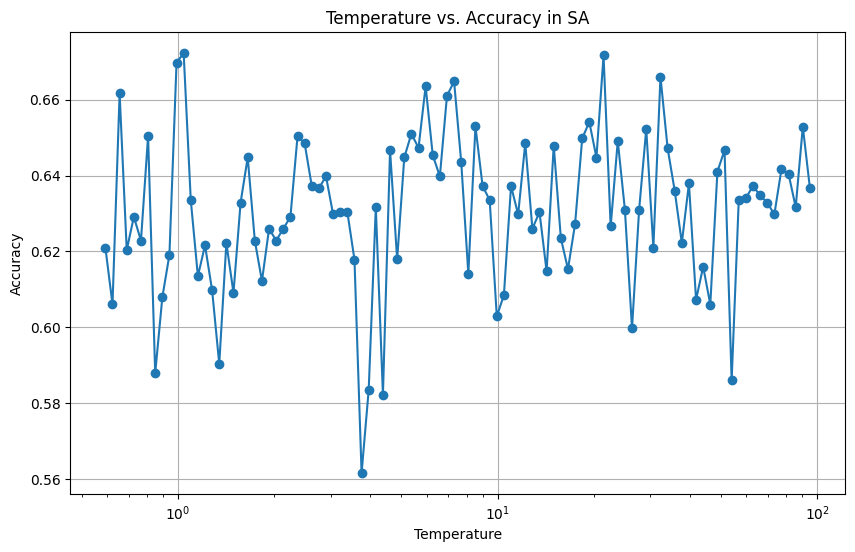

In [10]:
# Plot temperature vs. accuracy for SA
plt.figure(figsize=(10, 6))
plt.plot(temperatures, scores, marker='o')
plt.title("Temperature vs. Accuracy in SA")
plt.xlabel("Temperature")
plt.ylabel("Accuracy")
plt.xscale('log')  # Log scale for better visualization
plt.grid()
plt.savefig("sa_temperature_accuracy.png")
plt.show()

### 4. Confusion Matrix
Visualize the confusion matrix for both models trained on the selected features from GA and SA.

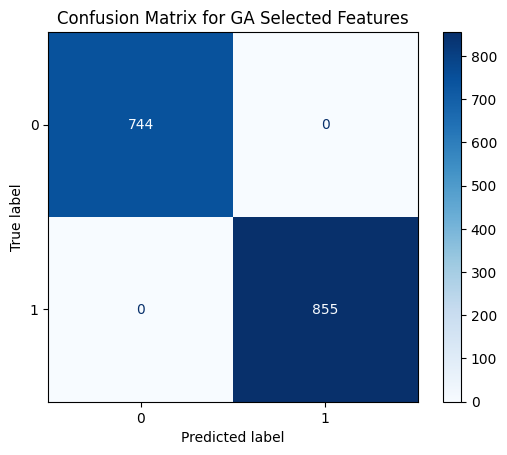

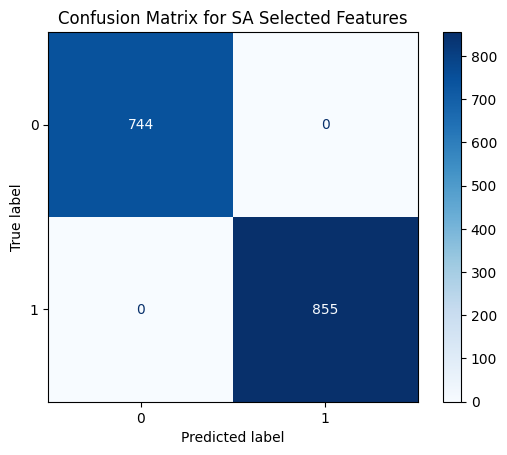

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(selected_features, title):
    model = DecisionTreeClassifier()
    model.fit(X.iloc[:, selected_features], y)
    y_pred = model.predict(X.iloc[:, selected_features])
    
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.savefig("Confusion Matrix for GA Selected Features.png")
    plt.savefig("Confusion Matrix for SA Selected Features.png")
    plt.show()

# Confusion matrix for GA and SA selected features
plot_confusion_matrix(selected_features_ga, "Confusion Matrix for GA Selected Features")
plot_confusion_matrix(current_state, "Confusion Matrix for SA Selected Features")

### 5. Box Plot of Accuracy Across Cross-Validation Folds
Visualize the accuracy distribution across cross-validation folds for both GA and SA selected features.

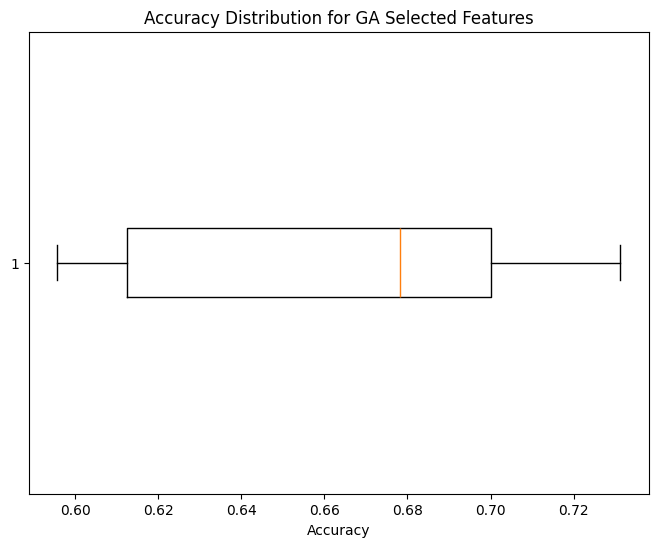

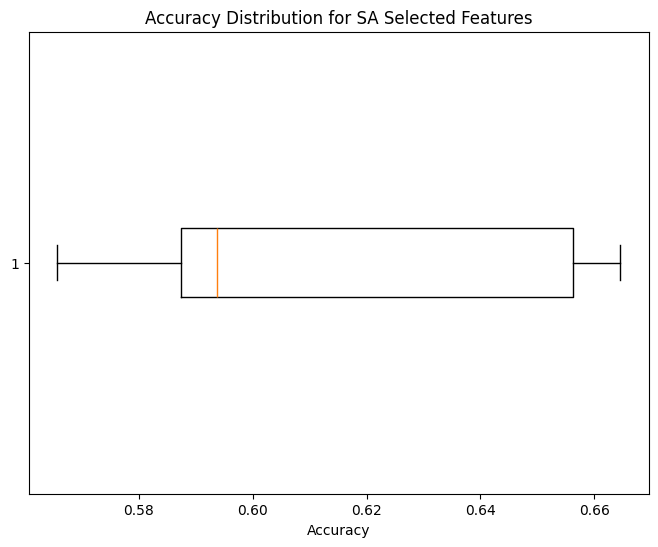

In [18]:
# Box plot for accuracy distribution
def plot_accuracy_distribution(selected_features, title):
    model = DecisionTreeClassifier()
    cv_scores = cross_val_score(model, X.iloc[:, selected_features], y, cv=5)
    
    plt.figure(figsize=(8, 6))
    plt.boxplot(cv_scores, vert=False)
    plt.title(title)
    plt.xlabel("Accuracy")
    plt.savefig("Accuracy Distribution for GA Selected Features.png")
    plt.savefig("Accuracy Distribution for SA Selected Features.png")
    plt.show()

# Accuracy distribution for GA and SA
plot_accuracy_distribution(selected_features_ga, "Accuracy Distribution for GA Selected Features")
plot_accuracy_distribution(current_state, "Accuracy Distribution for SA Selected Features")

### 4. Conclusion

#### Summary
- **Effectiveness**: Summarize how GA and SA balance optimization and computational efficiency.
- **Comparison**: Highlight differences in selected features, computational time, and effectiveness relative to Part 1 methods.

This comprehensive analysis of wrapper-based feature selection techniques will provide valuable insights into optimal feature selection approaches for various models.